In [143]:
#Input dataset format:  timestamp, src, dest, length, src port, dst port

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import math

from datetime import datetime

print('done.')
#print('')
#print("Is CUDA available?", torch.cuda.is_available())

done.


In [144]:
#Load data
print('Loading data...')
data = np.load('data_correct.npy')
nsamples = data.shape[0] 
max_src = data[:,1].max()
data = torch.tensor(data).float()
print("Samples:", nsamples,"\n") 

#Prepare timestamps
print('Pre-processing timestamps...\n')
for i in range(int(max_src)):
    timestamps = data[ data[:,1] == i, 0 ] 
    timestamps[1:] = timestamps[1:] - timestamps[:-1] 
    timestamps[0] = 0 
    data[ data[:,1] == i, 0 ] = timestamps 

#Shuffle the data
print('Shuffle the bit...\n')
data = data[ torch.randperm(data.shape[0]) ]
 
#Split in training, validation and test set
print('Creating dataset...')
train = data[:int(nsamples*0.6)]
validation = data[int(nsamples*0.6):int(nsamples*0.8)]
test = data[int(nsamples*0.8):]


print("Samples train:", train.shape[0])
print("Samples validation:", validation.shape[0])
print("Samples test:", test.shape[0])
print("Total samples:", data.shape[0])

print('\ndone.')

Loading data...
Samples: 2054165 

Pre-processing timestamps...

Shuffle the bit...

Creating dataset...
Samples train: 1232499
Samples validation: 410833
Samples test: 410833
Total samples: 2054165

done.


In [145]:
#Define network
class Net(nn.Module): 
    def __init__(self): 
        super(Net,self).__init__() 
        self.loss_fn = nn.CrossEntropyLoss()     #LogSoftmax + ClassNLL Loss 
        
        self.layers = nn.Sequential(             #Defining layers
            nn.Linear(5,30),                     #Input "mac source","Destination","source port","dest port"
            nn.ReLU(), 
            nn.Linear(30,90), 
            nn.ReLU(), 
            nn.Linear(90,90)            
            #nn.Softmax()   
        )
        
    def forward(self,x):                         #Definig forward passage
        return self.layers(x)
    
    def loss_function(self, net_out, target): 
        return self.loss_fn(net_out, target)
    
print('done.')

done.


In [146]:
#Hyper-params
stop_at = train.shape[0] - 1
stop_at = 100000         #Speeds up a quick test by reducing the dataset
nbatch = 64               #Batch size
lear_rate = 1e-4
n = 101                    #Epochs
stamp = 10               #Print every stamps epochs

In [154]:
# network init
print("Creating the model...")
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
net.to(device)
optimizer = optim.Adam(params=net.parameters(), lr=lear_rate)
print("Ready!")

Creating the model...
Ready!


In [148]:
max_acc = 0
listLoss = []
listAccuracy_val = []

#Train
print("Start training...")
dateTimeObj_start = datetime.now()
print(dateTimeObj_start)

for epoch in range(n):  

    dateTimeObj_start= datetime.now()    
    net.train()
    mean_loss = 0.
    correct = 0    
    for it,batch in enumerate(train.split(nbatch)): 
        if it*nbatch > stop_at: break
        batch = batch.to(device)            #Move batch to GPU memory if there is
        targets = batch[:,1].long()         #Casting to long
        net_input = batch[:,(0,2,3,4,5)]    #Selectin the input from the dataloader (1 are the target)
        optimizer.zero_grad()               #Set gradients to zero, thri is not an rnn

        output = net(net_input)                     #Net inference
        loss = net.loss_function(output, targets)   #That loss hides the one-hot encoding
        loss.backward()                             #Back propagation
        optimizer.step()                            #Updating gradients
        mean_loss += loss.item()                    #Average of inferences

    dateTimeObj_end = datetime.now()

    net.eval()            #Evaluation, there is no update of the weights. Just a check for overfitting
    with torch.no_grad(): #Do not modify the net
        correct_eval = 0
        for it_eval,batch_eval in enumerate(validation.split(nbatch)):  
            if it_eval*nbatch > stop_at: break
            targets_eval = batch_eval[:,1].long()
            net_input_eval = batch_eval[:,(0,2,3,4,5)]
            optimizer.zero_grad()

            output_eval = net(net_input_eval)
            _, predicted_eval = torch.max(output_eval.data, 1)      #Max value becomes 1, others are set to zero
            correct_eval += (predicted_eval == targets_eval).sum()  #Sum of correct predictions

    tot = it_eval*nbatch
    accuracy_eval = 1.*correct_eval/tot

    
    if (epoch >= n-math.floor(n-n*0.1)):
        listLoss.append(mean_loss/it)
        listAccuracy_val.append(accuracy_eval)

    if epoch%stamp == 0 or epoch == n-1: print(f"Epoch {epoch}, MeanLoss: {round((mean_loss/it), 3)}, Accuracy val: {round((100.*accuracy_eval.item()),3)}%")

#torch.save(model.state_dict(), PATH)
dateTimeObj_end = datetime.now()
print()
print("Trained for " + str(n) + " epochs in: ", dateTimeObj_end-dateTimeObj_start)
print()

max_val = max(listAccuracy_val)
for i,element in enumerate(listAccuracy_val):
    if element == max_val:
        break
print("Best value of validation is:", round(element.item(),5)*100,"% at", i, "epoch")
print()

Start training...
2021-03-05 20:15:15.519668
Epoch 0, MeanLoss: 183.769, Accuracy val: 6.307%
Epoch 10, MeanLoss: 15.197, Accuracy val: 13.823%
Epoch 20, MeanLoss: 10.552, Accuracy val: 14.485%
Epoch 30, MeanLoss: 7.149, Accuracy val: 18.744%
Epoch 40, MeanLoss: 5.486, Accuracy val: 22.86%
Epoch 50, MeanLoss: 4.484, Accuracy val: 23.833%
Epoch 60, MeanLoss: 3.87, Accuracy val: 27.806%
Epoch 70, MeanLoss: 3.378, Accuracy val: 28.249%
Epoch 80, MeanLoss: 3.115, Accuracy val: 33.484%
Epoch 90, MeanLoss: 2.938, Accuracy val: 33.022%
Epoch 100, MeanLoss: 2.834, Accuracy val: 37.785%

Trained for 101 epochs in:  0:00:01.719212

Best value of validation is: 37.785000000000004 % at 89 epoch



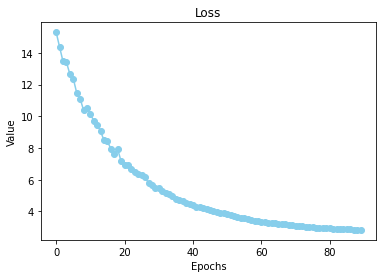

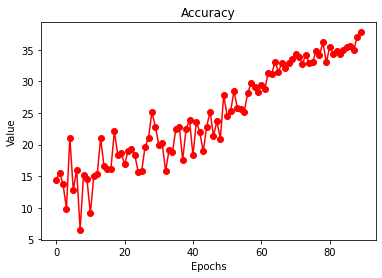

In [152]:
#Graphic
listLoss = np.asarray(listLoss, dtype=np.float32)
listAccuracy_val = np.asarray(listAccuracy_val, dtype=np.float32)

epochs = range(math.floor(n-n*0.1)) #In order to exlude the first 10% of values, which may be not significant

df_train = pd.DataFrame({'Epochs': epochs, 'Loss': listLoss})
df_acc_val = pd.DataFrame({'Epochs': epochs, 'Accuracy': listAccuracy_val*100})
    
#Loss plot
plt.plot( 'Epochs', 'Loss', data = df_train, linestyle='-', marker='o', color = 'skyblue' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.show()

#Accuracy plot
plt.plot( 'Epochs', 'Accuracy', data = df_acc_val, linestyle='-', marker='o', color = 'red' )
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.show()

In [150]:
#Test
net.eval() #Evaluation
with torch.no_grad(): 
    correct = 0
    for it,batch in enumerate(test.split(64)): 
        #if it*64 > stop_at: break #limit at 100k tuple for each batch
            
        batch = batch.to(device) 
        targets = batch[:,1].long()
        net_input = batch[:,(0,2,3,4,5)]
        
        output = net(net_input) 
        _, predicted = output.max(dim=1) 
        correct += (predicted == targets).sum() 

    score = (100. * correct / (it*64)).item()    
    print(f"Accuracy test: {round(score,3)} %")

Accuracy test: 37.744 %


In [151]:
#The above result is a sample obtained with 101 epochs on 5% of the dataset